## Calbration of classifiers in R
We load R functions and libraries


In [ ]:
source("calfunc.R")
source("calibrationMethods.R")

set.seed(0) 
require(caret)

library(MASS)

library("RWeka")

### Reading Data
We read a dataset and we split 50% Train 25% Validation and 25% Test

In [ ]:
datos <- read.arff("data/kr-vs-kp.arff")
datos <- read.arff("data/credit-g.arff")

posParamEstudio<-length(datos[1,])
nomParamEstudio<-names(datos)[posParamEstudio]
#datos<-datos[complete.cases(datos),]
# nomclasse<-names(datos)[length(names(datos))]
tam<-length(datos[,1])
# print(tam)
#mnom<-nomclasses[id]
numclass<-(length(levels(datos[,posParamEstudio])))
ob<-paste(nomParamEstudio,"~.",sep="")
w<-datos
indiceStrat<-createDataPartition(w[,nomParamEstudio], p = 0.5,list=FALSE)
train<-w[indiceStrat,]
test<-w[-indiceStrat,] 

indiceStrat<-createDataPartition(train[,nomParamEstudio], p = 0.5,list=FALSE)
validation<-train[indiceStrat,]
trainv<-train[-indiceStrat,] 

### Learn Models and calibrate probabilities
We read a dataset and we split 50% Train 25% Validation and 25% Test


In [7]:
 model <- J48(ob, data = trainv, control = Weka_control(U = TRUE,A=TRUE))
predprobtemp<-predict(model, newdata = test,type="prob")
predprobval<-predict(model, newdata = validation,type="prob")
#calibration
#predprobcal<-PAV1vsAll(as.factor(as.double(validation[[nomParamEstudio]])),predprobval,predprobtemp)
predprobcal<-plattCal(as.factor(as.double(validation[[nomParamEstudio]])),predprobval,predprobtemp)


NB <- make_Weka_classifier("weka/classifiers/bayes/NaiveBayes")
model <- NB(ob, data = trainv)
predprobtempNB<-predict(model, newdata = test,type="prob")
predprobvalNB<-predict(model, newdata = validation,type="prob")
#calibration
predprobcalNB<-plattCal(as.factor(as.double(validation[[nomParamEstudio]])),predprobvalNB,predprobtempNB)


### Calibration Plots

Plots and measures before calibration


[1] "J48 MSE 0.224756739185762"
[1] "J48 cal 0.217756739185762 ref 0.007"
[1] "NB MSE 0.207564100091943"
[1] "NB cal 0.207564100091943 ref 0"


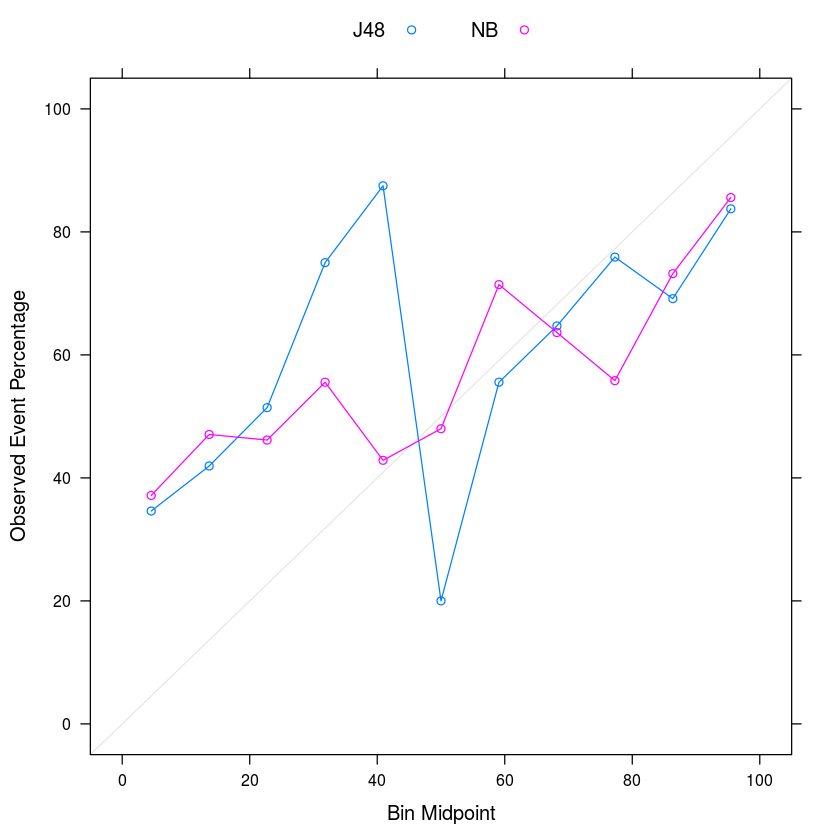

In [8]:
testProbs <- data.frame(obs =test[[nomParamEstudio]] ,NB=predprobtempNB[,1],J48=predprobtemp[,1])

calPlotData <- calibration(obs ~ J48+NB, data = testProbs)

xyplot(calPlotData, auto.key = list(columns = 2))


res<-MSEdecomp(cbind(as.double(test[[nomParamEstudio]])-1,predprobtemp[,2]))
print(paste("J48 MSE",MSE2(cbind(as.double(test[[nomParamEstudio]])-1,predprobtemp[,2]))))
print(paste("J48 cal",res$cal,"ref",res$ref))

res<-MSEdecomp(cbind(as.double(test[[nomParamEstudio]])-1,predprobtempNB[,2]))
print(paste("NB MSE",MSE2(cbind(as.double(test[[nomParamEstudio]])-1,predprobtempNB[,2]))))
print(paste("NB cal",res$cal,"ref",res$ref))


Plots and measures after calibration


[1] "calJ48 MSE 0.194582784296051"
[1] "calJ48 cal 0.187582784296051 ref 0.007"
[1] "calNB MSE 0.185802910787163"
[1] "calNB cal 0.185802910787163 ref 0"


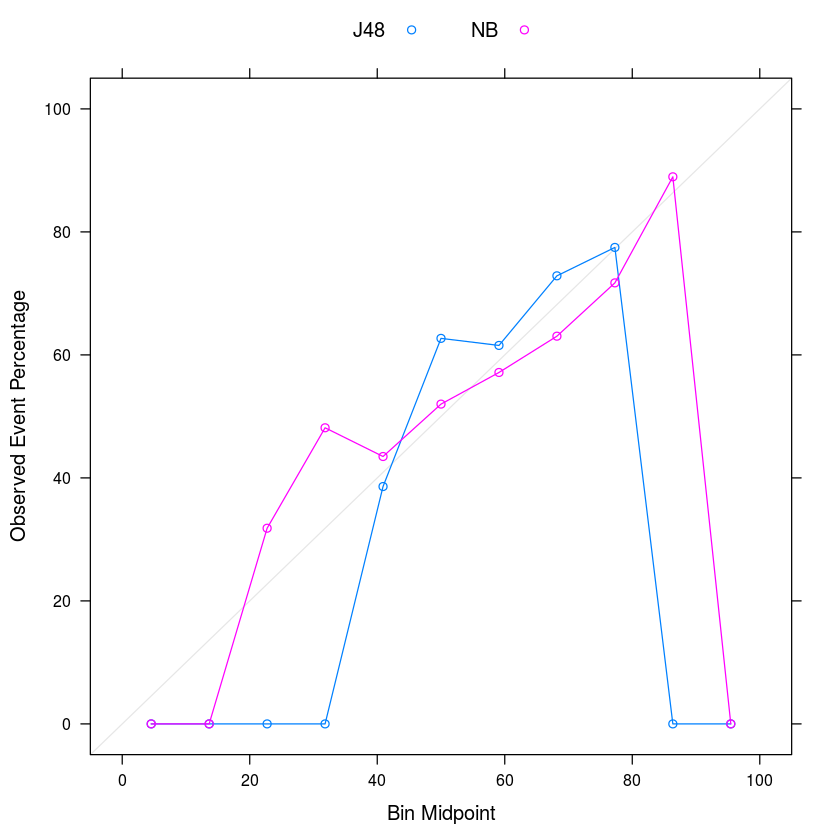

In [9]:
testProbs <- data.frame(obs =test[[nomParamEstudio]] ,NB=predprobcalNB[,1],J48=predprobcal[,1])

calPlotData <- calibration(obs ~  J48+NB, data = testProbs)

xyplot(calPlotData, auto.key = list(columns = 2))

res<-MSEdecomp(cbind(as.double(test[[nomParamEstudio]])-1,predprobcal[,2]))
print(paste("calJ48 MSE",MSE2(cbind(as.double(test[[nomParamEstudio]])-1,predprobcal[,2]))))
print(paste("calJ48 cal",res$cal,"ref",res$ref))

res<-MSEdecomp(cbind(as.double(test[[nomParamEstudio]])-1,predprobcalNB[,2]))
print(paste("calNB MSE",MSE2(cbind(as.double(test[[nomParamEstudio]])-1,predprobcalNB[,2]))))
print(paste("calNB cal",res$cal,"ref",res$ref))
